In [0]:
!pip install konlpy==0.4.

ERROR: Could not find a version that satisfies the requirement konlpy== (from versions: 0.3.0, 0.3.1, 0.3.2, 0.3.3, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.5.0, 0.5.1)
ERROR: No matching distribution found for konlpy==


In [0]:
import konlpy 

konlpy.__version__

'0.5.1'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=feee595ce39919ea24a0de636dad766caf84e83366af0243e8b9c9e191f19765
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models, layers
from keras.preprocessing import text, sequence
import re
import warnings
import gc
import keras
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/0.Projects/Korean Language Models/ratings.txt', sep='\t', encoding='utf-8')

In [0]:
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [0]:
df.drop('id', axis=1, inplace=True)

In [0]:
texts = df.loc[:, ['document', 'label']]

In [0]:
texts.shape

(200000, 2)

In [0]:
texts = texts.drop_duplicates()

In [0]:
texts.shape

(194766, 2)

In [0]:
texts.head()

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [0]:
x_train, x_test, y_train, y_test = train_test_split(texts['document'], texts['label'], test_size=0.4, stratify=texts['label'], random_state=42)

In [0]:
target = y_train.copy()
texts = x_train.copy()

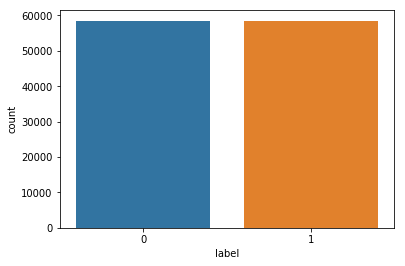

In [0]:
sns.countplot(target)

In [0]:
target.shape

(116859,)

In [0]:
texts.shape

(116859,)

In [0]:
# 초성 리스트. 00 ~ 18
CHOSUNG_LIST = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
# 중성 리스트. 00 ~ 20
JUNGSUNG_LIST = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
# 종성 리스트. 00 ~ 27 + 1(1개 없음)
JONGSUNG_LIST = ['*', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

ALPHABET_LIST = ['A', 'B', 'C', 'D', 'E','F','G','H','I','J','K','L','N','M','O','P','Q','R','S','T','U','V','W','X','Y','Z']

NUMBER_LIST = ['0','1','2','3','4','5','6','7','8','9']

def korean_to_be_split(korean_word):
    r_lst = []
    for w in list(korean_word.strip()):
        ## 영어인 경우 구분해서 작성함. 
        if '가'<=w<='힣':
            ## 588개 마다 초성이 바뀜. 
            ch1 = (ord(w) - ord('가'))//588
            ## 중성은 총 28가지 종류
            ch2 = ((ord(w) - ord('가')) - (588*ch1)) // 28
            ch3 = (ord(w) - ord('가')) - (588*ch1) - 28*ch2
            r_lst.append([CHOSUNG_LIST[ch1], JUNGSUNG_LIST[ch2], JONGSUNG_LIST[ch3]])
        else:
            r_lst.append([w])
    return r_lst
    

In [0]:
test_text = "안녕하세요"

In [3]:
korean_to_be_split(test_text)

[['ㅇ', 'ㅏ', 'ㄴ'],
 ['ㄴ', 'ㅕ', 'ㅇ'],
 ['ㅎ', 'ㅏ', '*'],
 ['ㅅ', 'ㅔ', '*'],
 ['ㅇ', 'ㅛ', '*']]

In [0]:
texts= pd.DataFrame(texts)

In [0]:
texts.head()

,document
170168,결코 내가 감수성이 모자란 사람은 아니지만 감동이 크지도 않고 영하보는내내 지루하기...
38133,제 취향적 이고 우울한 마음을 완전히 날려버리고 슬픈내용을 본뒤 마음을 정화시켜주네요.
85814,미나가 물 속 가방에서 아이를 꺼낼 때 그런 생각이 들었다. 어떤 약자는 일신의 안...
154150,원작을 안본분들 원작보시면 이거 평점도 주기싫을것입니다 원래 원작이있는걸 애니화 영...
161165,제목이 안 어울려


In [0]:
pattern = re.compile(r'[^ㄱ-ㅎ가-힣a-zA-Z0-9]+')

def brief_pp_text(x):
  result = re.sub(pattern, ' ', x)
  return result

In [0]:
texts['pp']= texts['document'].astype('str').apply(brief_pp_text)

In [0]:
texts['split'] = texts['pp'].apply(korean_to_be_split)

In [0]:
texts['split'].head()

170168    [[ㄱ, ㅕ, ㄹ], [ㅋ, ㅗ, *], [ ], [ㄴ, ㅐ, *], [ㄱ, ㅏ, ...
38133     [[ㅈ, ㅔ, *], [ ], [ㅊ, ㅟ, *], [ㅎ, ㅑ, ㅇ], [ㅈ, ㅓ, ...
85814     [[ㅁ, ㅣ, *], [ㄴ, ㅏ, *], [ㄱ, ㅏ, *], [ ], [ㅁ, ㅜ, ...
154150    [[ㅇ, ㅝ, ㄴ], [ㅈ, ㅏ, ㄱ], [ㅇ, ㅡ, ㄹ], [ ], [ㅇ, ㅏ, ...
161165    [[ㅈ, ㅔ, *], [ㅁ, ㅗ, ㄱ], [ㅇ, ㅣ, *], [ ], [ㅇ, ㅏ, ...
Name: split, dtype: object

In [0]:
texts.head()

,document,pp,split
170168,결코 내가 감수성이 모자란 사람은 아니지만 감동이 크지도 않고 영하보는내내 지루하기...,결코 내가 감수성이 모자란 사람은 아니지만 감동이 크지도 않고 영하보는내내 지루하기...,"[[ㄱ, ㅕ, ㄹ], [ㅋ, ㅗ, *], [ ], [ㄴ, ㅐ, *], [ㄱ, ㅏ, ..."
38133,제 취향적 이고 우울한 마음을 완전히 날려버리고 슬픈내용을 본뒤 마음을 정화시켜주네요.,제 취향적 이고 우울한 마음을 완전히 날려버리고 슬픈내용을 본뒤 마음을 정화시켜주네요,"[[ㅈ, ㅔ, *], [ ], [ㅊ, ㅟ, *], [ㅎ, ㅑ, ㅇ], [ㅈ, ㅓ, ..."
85814,미나가 물 속 가방에서 아이를 꺼낼 때 그런 생각이 들었다. 어떤 약자는 일신의 안...,미나가 물 속 가방에서 아이를 꺼낼 때 그런 생각이 들었다 어떤 약자는 일신의 안위...,"[[ㅁ, ㅣ, *], [ㄴ, ㅏ, *], [ㄱ, ㅏ, *], [ ], [ㅁ, ㅜ, ..."
154150,원작을 안본분들 원작보시면 이거 평점도 주기싫을것입니다 원래 원작이있는걸 애니화 영...,원작을 안본분들 원작보시면 이거 평점도 주기싫을것입니다 원래 원작이있는걸 애니화 영...,"[[ㅇ, ㅝ, ㄴ], [ㅈ, ㅏ, ㄱ], [ㅇ, ㅡ, ㄹ], [ ], [ㅇ, ㅏ, ..."
161165,제목이 안 어울려,제목이 안 어울려,"[[ㅈ, ㅔ, *], [ㅁ, ㅗ, ㄱ], [ㅇ, ㅣ, *], [ ], [ㅇ, ㅏ, ..."


In [0]:
def j_m_join(x):
  join_result = []
  for i in x:
    for k in  i:
      result = ''.join(k)
      join_result.append(result)
  return join_result

In [0]:
texts['join'] = texts['split'].apply(j_m_join)

In [0]:
full_text = texts['join'].tolist() + CHOSUNG_LIST + JUNGSUNG_LIST + JONGSUNG_LIST + ALPHABET_LIST + NUMBER_LIST

In [0]:
token = text.Tokenizer(filters='', split=',')

In [0]:
token.fit_on_texts(full_text)

In [0]:
token.index_word

{1: '*',
 2: 'ㅇ',
 3: ' ',
 4: 'ㅏ',
 5: 'ㄴ',
 6: 'ㅣ',
 7: 'ㄱ',
 8: 'ㄹ',
 9: 'ㅡ',
 10: 'ㅁ',
 11: 'ㅓ',
 12: 'ㅗ',
 13: 'ㅈ',
 14: 'ㄷ',
 15: 'ㅅ',
 16: 'ㅎ',
 17: 'ㅜ',
 18: 'ㅕ',
 19: 'ㅂ',
 20: 'ㅐ',
 21: 'ㅔ',
 22: 'ㅘ',
 23: 'ㅆ',
 24: 'ㅊ',
 25: 'ㅋ',
 26: 'ㅍ',
 27: 'ㅌ',
 28: 'ㅛ',
 29: 'ㄲ',
 30: 'ㅢ',
 31: 'ㅚ',
 32: 'ㅑ',
 33: 'ㄸ',
 34: 'ㅉ',
 35: 'ㅄ',
 36: 'ㅝ',
 37: 'ㅠ',
 38: 'ㄶ',
 39: 'ㅟ',
 40: 'ㅃ',
 41: '1',
 42: 'ㅙ',
 43: '0',
 44: 'ㅖ',
 45: 'o',
 46: '2',
 47: '3',
 48: 't',
 49: 's',
 50: 'e',
 51: '9',
 52: '4',
 53: '5',
 54: 'b',
 55: '8',
 56: 'd',
 57: 'c',
 58: 'a',
 59: '7',
 60: 'g',
 61: 'ㅀ',
 62: 'ㄻ',
 63: 'i',
 64: 'v',
 65: 'n',
 66: 'ㄺ',
 67: 'r',
 68: '6',
 69: 'm',
 70: 'ㅞ',
 71: 'l',
 72: 'ㅒ',
 73: 'h',
 74: 'f',
 75: 'u',
 76: 'p',
 77: 'y',
 78: 'k',
 79: 'w',
 80: 'x',
 81: 'ㄼ',
 82: 'j',
 83: 'z',
 84: 'ㄵ',
 85: 'ㄳ',
 86: 'q',
 87: 'ㄾ',
 88: 'ㄿ',
 89: 'ㄽ'}

In [0]:
text_index = token.texts_to_sequences(texts['join'].values)

In [0]:
# check max len

max_len_checker = []
for i in text_index:
  result =len(i)
#   print(result)
  max_len_checker.append(result)

np.max(np.array(max_len_checker))

418

In [0]:
text_pad = sequence.pad_sequences(text_index, 420, padding='pre', dtype=np.int8)

In [0]:
text_pad.shape

(116859, 420)

In [0]:
y_train.shape

(116859,)

In [0]:
label = y_train.copy()

In [0]:
label = label.values

In [0]:
label

array([0, 1, 1, ..., 1, 1, 0])

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
text_pad.shape

(116859, 420)

In [0]:
target.shape

(116859,)

In [0]:
x_train, x_test , y_train, y_test = train_test_split(text_pad, target, test_size=0.2, stratify=target, random_state=1228)

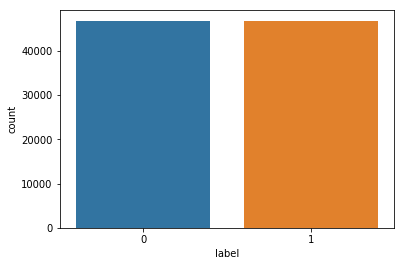

In [0]:
sns.countplot(y_train)

In [0]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(93487, 420)
(23372, 420)
(93487,)
(23372,)


In [0]:
max_len = len(token.index_word)

In [0]:
max_len

89

In [0]:
from keras import backend as K

input_tensor = keras.layers.Input(shape = (420, ))

x_emb = keras.layers.Embedding(max_len+1, 300)(input_tensor)
x = keras.layers.SpatialDropout1D(0.4)(x_emb)
x_1 = keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x_1 = keras.layers.BatchNormalization()(x_1)
# x_1 = keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x_1)
x_1_1 = keras.layers.MaxPool1D()(x_1)
x_1_2 = keras.layers.AvgPool1D()(x_1)
concat_x_1 = keras.layers.Concatenate()([x_1_1, x_1_2])

x_2 = keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
x_2 = keras.layers.BatchNormalization()(x_2)
# x_2 = keras.layers.Conv1D(256, 5, padding='same', activation='relu')(x_2)
x_2_1 = keras.layers.MaxPool1D()(x_2)
x_2_2 = keras.layers.AvgPool1D()(x_2)
concat_x_2 = keras.layers.Concatenate()([x_2_1, x_2_2])

x_3 = keras.layers.Conv1D(128, 7, padding='same', activation='relu')(x)
x_3 = keras.layers.BatchNormalization()(x_3)
# x_3 = keras.layers.Conv1D(256, 7, padding='same', activation='relu')(x_3)
x_3_1 = keras.layers.MaxPool1D()(x_3)
x_3_2 = keras.layers.AvgPool1D()(x_3)
concat_x_3 = keras.layers.Concatenate()([x_3_1, x_3_2])

x_4 = keras.layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x_4 = keras.layers.BatchNormalization()(x_4)
# x_4 = keras.layers.Conv1D(256, 10, padding='same', activation='relu')(x_4)
x_4_1 = keras.layers.MaxPool1D()(x_4)
x_4_2 = keras.layers.AvgPool1D()(x_4)
concat_x_4 = keras.layers.Concatenate()([x_4_1, x_4_2])

x_5 = keras.layers.Conv1D(128, 12, padding='same', activation='relu')(x)
x_5 = keras.layers.BatchNormalization()(x_5)
# x_5 = keras.layers.Conv1D(256, 1, padding='same', activation='relu')(x_5)
x_5_1 = keras.layers.MaxPool1D()(x_5)
x_5_2 = keras.layers.AvgPool1D()(x_5)
concat_x_5 = keras.layers.Concatenate()([x_5_1, x_5_2])

concat = keras.layers.Concatenate()([concat_x_1, concat_x_2, concat_x_3, concat_x_4, concat_x_5])

x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(concat)
x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(x)

x_1 = layers.GlobalAvgPool1D()(x)
x_2 = layers.GlobalMaxPool1D()(x)
x = layers.Concatenate()([x_1, x_2])

x_out = keras.layers.Dense(512, activation='relu')(x)
x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(256, activation='relu')(x_out)
x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(128, activation='relu')(x_out)
output = keras.layers.Dense(1, activation='sigmoid')(x_out)



model = keras.models.Model(input_tensor, output)

opt = keras.optimizers.adam(lr = 0.01, beta_1=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# my_call_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 420)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 420, 512)     46080       input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 420, 512)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 420, 256)     393472      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

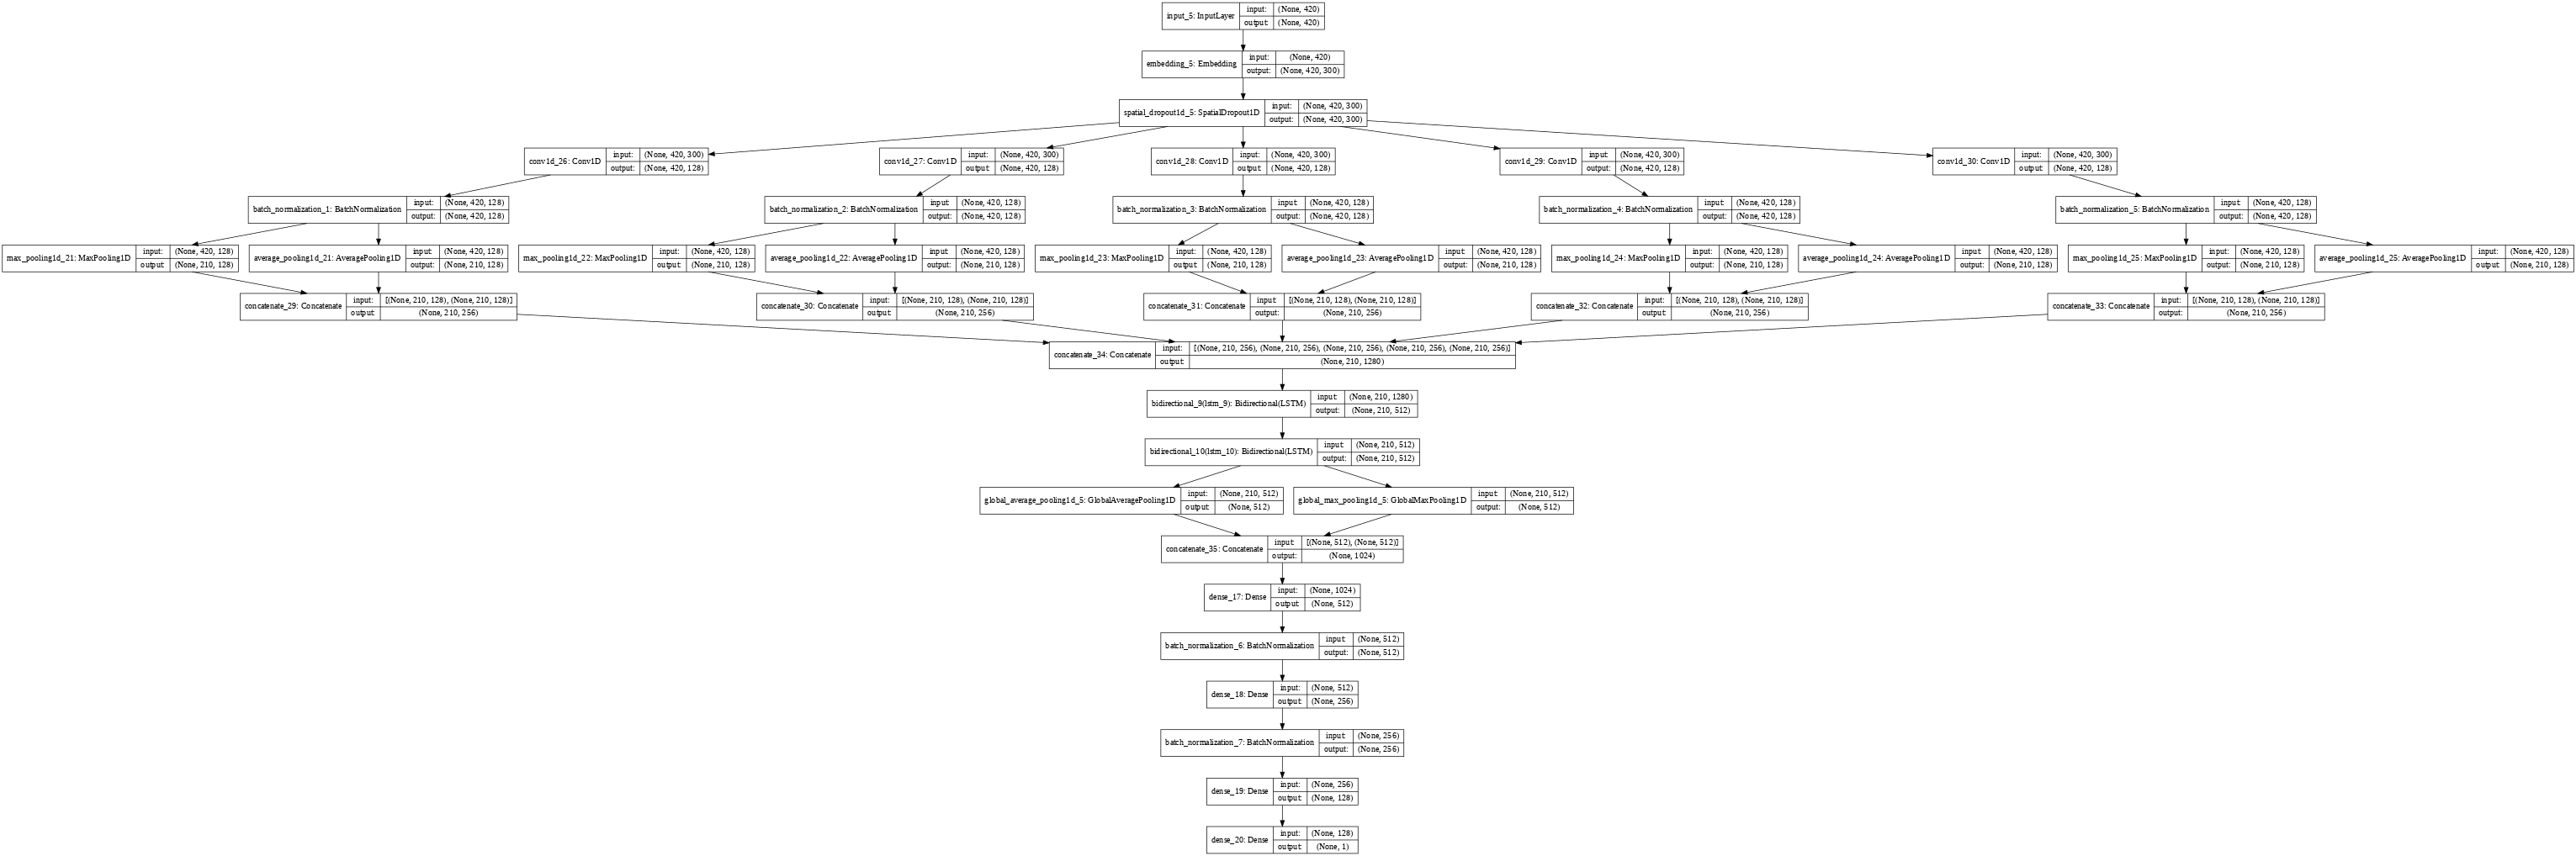

In [0]:
plot_model(model, show_shapes=True, dpi = 50)

In [0]:
history = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data =(x_test, y_test))

Train on 77906 samples, validate on 19477 samples
Epoch 1/100
77906/77906 [==============================] - 865s 11ms/step - loss: 0.7293 - acc: 0.5127 - val_loss: 0.6797 - val_acc: 0.5652
Epoch 2/100
77906/77906 [==============================] - 857s 11ms/step - loss: 0.6173 - acc: 0.6482 - val_loss: 0.6390 - val_acc: 0.6357
Epoch 3/100
77906/77906 [==============================] - 856s 11ms/step - loss: 0.5868 - acc: 0.6786 - val_loss: 0.6091 - val_acc: 0.6852
Epoch 4/100
77906/77906 [==============================] - 853s 11ms/step - loss: 0.5678 - acc: 0.6976 - val_loss: 1.1193 - val_acc: 0.5280
Epoch 5/100
77906/77906 [==============================] - 857s 11ms/step - loss: 0.5570 - acc: 0.7048 - val_loss: 1.2600 - val_acc: 0.5329
Epoch 6/100
77906/77906 [==============================] - 857s 11ms/step - loss: 0.5464 - acc: 0.7124 - val_loss: 0.5887 - val_acc: 0.6822
Epoch 7/100
77906/77906 [==============================] - 855s 11ms/step - loss: 0.5499 - acc: 0.7132 - val_l

In [0]:
model.layers[1].get_weights()

[array([[-0.04860985, -0.01680002,  0.02526994, ...,  0.04584473,
          0.02398367,  0.09792779],
        [-0.04756419, -0.05555842,  0.06825601, ...,  0.06038714,
          0.1021572 ,  0.0531422 ],
        [-0.11358815, -0.00291689,  0.0984001 , ...,  0.04541061,
          0.04543434,  0.08371761],
        ...,
        [ 0.04795128, -0.00080342, -0.04604045, ..., -0.00799669,
         -0.00108376,  0.04933152],
        [ 0.02526692, -0.04268016, -0.04986965, ...,  0.00142615,
          0.01547599,  0.03784601],
        [ 0.02434461,  0.00734638,  0.03634543, ..., -0.00022657,
         -0.04473355, -0.04857786]], dtype=float32)]

# LSTM and global a + global m = 81

In [0]:
from keras import backend as K

input_tensor = keras.layers.Input(shape = (420, ))

x_emb = keras.layers.Embedding(max_len+1, 300)(input_tensor)

x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(x_emb)
x = keras.layers.Conv1D(128, 7, activation='relu', padding='valid')(x)

x_1 = layers.GlobalAvgPool1D()(x)
x_2 = layers.GlobalMaxPool1D()(x)
x = layers.Concatenate()([x_1, x_2])

x_out = keras.layers.Dense(512, activation='relu')(x)
# x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(256, activation='relu')(x_out)
# x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(128, activation='relu')(x_out)
output = keras.layers.Dense(1, activation='sigmoid')(x_out)



model = keras.models.Model(input_tensor, output)

opt = keras.optimizers.adam(lr = 0.01, beta_1=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# my_call_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data =(x_test, y_test))




Train on 77906 samples, validate on 19477 samples
Epoch 1/100





77906/77906 [==============================] - 480s 6ms/step - loss: 0.7028 - acc: 0.5008 - val_loss: 0.6934 - val_acc: 0.5006
Epoch 2/100
77906/77906 [==============================] - 470s 6ms/step - loss: 0.6884 - acc: 0.5327 - val_loss: 0.6772 - val_acc: 0.5648
Epoch 3/100
77906/77906 [==============================] - 470s 6ms/step - loss: 0.6988 - acc: 0.5393 - val_loss: 0.6770 - val_acc: 0.5576
Epoch 4/100
77906/77906 [==============================] - 470s 6ms/step - loss: 0.6278 - acc: 0.6231 - val_loss: 0.6085 - val_acc: 0.6590
Epoch 5/100
77906/77906 [==============================] - 470s 6ms/step - loss: 0.5462 - acc: 0.7068 - val_loss: 0.5262 - val_acc: 0.7153
Epoch 6/100
77906/77906 [==============================] - 471s 6ms/step - loss: 0.5023 - acc: 0.7433 - val_loss: 0.4961 - val_acc: 0.7439
Epoch 7/100
77906/77906 [==============================] - 471s 6ms/step - loss: 0.4830 - acc: 0.7593 - val_

KeyboardInterrupt: ignored

In [0]:
from keras import backend as K

input_tensor = keras.layers.Input(shape = (420, ))

x_emb = keras.layers.Embedding(max_len+1, 300)(input_tensor)

x_1 = keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x_emb)
x_1 = keras.layers.MaxPool1D()(x_1)

x_2 = keras.layers.Conv1D(256, 6, padding='same', activation='relu')(x_emb)
x_2 = keras.layers.MaxPool1D()(x_2)

x_3 = keras.layers.Conv1D(256, 9, padding='same', activation='relu')(x_emb)
x_3 = keras.layers.MaxPool1D()(x_3)

x_4 = keras.layers.Conv1D(256, 12, padding='same', activation='relu')(x_emb)
x_4 = keras.layers.MaxPool1D()(x_4)

x_5 = keras.layers.Conv1D(256, 15, padding='same', activation='relu')(x_emb)
x_5 = keras.layers.MaxPool1D()(x_5)


x_concat = keras.layers.Concatenate()([x_1, x_2, x_3, x_4, x_5])

x = keras.layers.Bidirectional(keras.layers.LSTM(256))(x_concat)

x_out = keras.layers.Dense(512, activation='relu')(x)
# x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(256, activation='relu')(x_out)
# x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(128, activation='relu')(x_out)
output = keras.layers.Dense(1, activation='sigmoid')(x_out)



model = keras.models.Model(input_tensor, output)

opt = keras.optimizers.adam(lr = 0.01, beta_1=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# my_call_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1)

In [0]:
history = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data =(x_test, y_test))

Train on 93487 samples, validate on 23372 samples
Epoch 1/100
93487/93487 [==============================] - 794s 8ms/step - loss: 0.6725 - acc: 0.5693 - val_loss: 0.6411 - val_acc: 0.6294
Epoch 2/100
93487/93487 [==============================] - 786s 8ms/step - loss: 0.6180 - acc: 0.6495 - val_loss: 0.6312 - val_acc: 0.6378
Epoch 3/100
93487/93487 [==============================] - 783s 8ms/step - loss: 0.6077 - acc: 0.6576 - val_loss: 0.6247 - val_acc: 0.6416
Epoch 4/100
93487/93487 [==============================] - 779s 8ms/step - loss: 0.6291 - acc: 0.6353 - val_loss: 0.6348 - val_acc: 0.6364
Epoch 5/100
93487/93487 [==============================] - 779s 8ms/step - loss: 0.6457 - acc: 0.6183 - val_loss: 0.6470 - val_acc: 0.6170
Epoch 6/100
93487/93487 [==============================] - 779s 8ms/step - loss: 0.6452 - acc: 0.6182 - val_loss: 0.6521 - val_acc: 0.6174
Epoch 7/100
93487/93487 [==============================] - 780s 8ms/step - loss: 0.6522 - acc: 0.6160 - val_loss: 0.

KeyboardInterrupt: ignored

In [0]:
from keras import backend as K

input_tensor = keras.layers.Input(shape = (420, ))

x_emb = keras.layers.Embedding(max_len+1, 300)(input_tensor)

# x_1 = keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x_emb)
# x_1 = keras.layers.MaxPool1D()(x_1)

# x_2 = keras.layers.Conv1D(256, 6, padding='same', activation='relu')(x_emb)
# x_2 = keras.layers.MaxPool1D()(x_2)

# x_3 = keras.layers.Conv1D(256, 9, padding='same', activation='relu')(x_emb)
# x_3 = keras.layers.MaxPool1D()(x_3)

# x_4 = keras.layers.Conv1D(256, 12, padding='same', activation='relu')(x_emb)
# x_4 = keras.layers.MaxPool1D()(x_4)

# x_5 = keras.layers.Conv1D(256, 15, padding='same', activation='relu')(x_emb)
# x_5 = keras.layers.MaxPool1D()(x_5)


# x_concat = keras.layers.Concatenate()([x_1, x_2, x_3, x_4, x_5])

x = keras.layers.Bidirectional(keras.layers.LSTM(256))(x_emb)

x_out = keras.layers.Dense(512, activation='relu')(x)
# x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(256, activation='relu')(x_out)
# x_out = keras.layers.BatchNormalization()(x_out)
x_out = keras.layers.Dense(128, activation='relu')(x_out)
output = keras.layers.Dense(1, activation='sigmoid')(x_out)



model = keras.models.Model(input_tensor, output)

opt = keras.optimizers.adam(lr = 0.01, beta_1=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# my_call_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1)

In [0]:
history = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data =(x_test, y_test))

Train on 93487 samples, validate on 23372 samples
Epoch 1/100
93487/93487 [==============================] - 527s 6ms/step - loss: 0.6925 - acc: 0.5487 - val_loss: 0.6861 - val_acc: 0.5468
Epoch 2/100
93487/93487 [==============================] - 524s 6ms/step - loss: 0.6751 - acc: 0.5749 - val_loss: 0.6744 - val_acc: 0.5843
Epoch 3/100
93487/93487 [==============================] - 524s 6ms/step - loss: 0.6691 - acc: 0.5895 - val_loss: 0.6667 - val_acc: 0.5999
Epoch 4/100
93487/93487 [==============================] - 523s 6ms/step - loss: 0.6654 - acc: 0.5957 - val_loss: 0.6675 - val_acc: 0.5997
Epoch 5/100
93487/93487 [==============================] - 523s 6ms/step - loss: 0.6648 - acc: 0.5981 - val_loss: 0.6671 - val_acc: 0.5949
Epoch 6/100
93487/93487 [==============================] - 523s 6ms/step - loss: 0.6626 - acc: 0.5993 - val_loss: 0.6638 - val_acc: 0.6008
Epoch 7/100
93487/93487 [==============================] - 524s 6ms/step - loss: 0.6642 - acc: 0.5934 - val_loss: 0.

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Testing Countvectorizer

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/0.Projects/Korean Language Models/ratings.txt', sep='\t', encoding='utf-8')

In [0]:
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [0]:
df.drop('id', axis=1, inplace=True)

In [0]:
texts = df.loc[:, ['document', 'label']]

In [0]:
texts.shape

(200000, 2)

In [0]:
texts = texts.drop_duplicates()

In [0]:
texts.shape

(194766, 2)

In [0]:
texts.head()

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [0]:
x_train, x_test, y_train, y_test = train_test_split(texts['document'], texts['label'], test_size=0.4, stratify=texts['label'], random_state=42)

In [0]:
target = y_train.copy()
texts = x_train.copy()

In [0]:
target.shape

(116859,)

In [0]:
texts.shape

(116859,)

In [0]:
texts.head()

170168    결코 내가 감수성이 모자란 사람은 아니지만 감동이 크지도 않고 영하보는내내 지루하기...
38133      제 취향적 이고 우울한 마음을 완전히 날려버리고 슬픈내용을 본뒤 마음을 정화시켜주네요.
85814     미나가 물 속 가방에서 아이를 꺼낼 때 그런 생각이 들었다. 어떤 약자는 일신의 안...
154150    원작을 안본분들 원작보시면 이거 평점도 주기싫을것입니다 원래 원작이있는걸 애니화 영...
161165                                            제목이 안 어울려
Name: document, dtype: object

In [0]:
cv_texts = pd.DataFrame(texts)

In [0]:
cv_texts['ja_mo'] = cv_texts['document'].astype('str').apply(korean_to_be_split)

In [0]:
cv_texts.head()

,document,ja_mo
170168,결코 내가 감수성이 모자란 사람은 아니지만 감동이 크지도 않고 영하보는내내 지루하기...,"[[ㄱ, ㅕ, ㄹ], [ㅋ, ㅗ, *], [ ], [ㄴ, ㅐ, *], [ㄱ, ㅏ, ..."
38133,제 취향적 이고 우울한 마음을 완전히 날려버리고 슬픈내용을 본뒤 마음을 정화시켜주네요.,"[[ㅈ, ㅔ, *], [ ], [ㅊ, ㅟ, *], [ㅎ, ㅑ, ㅇ], [ㅈ, ㅓ, ..."
85814,미나가 물 속 가방에서 아이를 꺼낼 때 그런 생각이 들었다. 어떤 약자는 일신의 안...,"[[ㅁ, ㅣ, *], [ㄴ, ㅏ, *], [ㄱ, ㅏ, *], [ ], [ㅁ, ㅜ, ..."
154150,원작을 안본분들 원작보시면 이거 평점도 주기싫을것입니다 원래 원작이있는걸 애니화 영...,"[[ㅇ, ㅝ, ㄴ], [ㅈ, ㅏ, ㄱ], [ㅇ, ㅡ, ㄹ], [ ], [ㅇ, ㅏ, ..."
161165,제목이 안 어울려,"[[ㅈ, ㅔ, *], [ㅁ, ㅗ, ㄱ], [ㅇ, ㅣ, *], [ ], [ㅇ, ㅏ, ..."


In [0]:
cv_texts['ja_mo'] = cv_texts['ja_mo'].apply(j_m_join)

In [0]:
cv_texts['ja_mo'] = cv_texts['ja_mo'].apply(lambda x : ''.join(x))

In [0]:
cv_texts.head()

,document,ja_mo
170168,결코 내가 감수성이 모자란 사람은 아니지만 감동이 크지도 않고 영하보는내내 지루하기...,ㄱㅕㄹㅋㅗ* ㄴㅐ*ㄱㅏ* ㄱㅏㅁㅅㅜ*ㅅㅓㅇㅇㅣ* ㅁㅗ*ㅈㅏ*ㄹㅏㄴ ㅅㅏ*ㄹㅏㅁㅇㅡㄴ...
38133,제 취향적 이고 우울한 마음을 완전히 날려버리고 슬픈내용을 본뒤 마음을 정화시켜주네요.,ㅈㅔ* ㅊㅟ*ㅎㅑㅇㅈㅓㄱ ㅇㅣ*ㄱㅗ* ㅇㅜ*ㅇㅜㄹㅎㅏㄴ ㅁㅏ*ㅇㅡㅁㅇㅡㄹ ㅇㅘㄴㅈㅓ...
85814,미나가 물 속 가방에서 아이를 꺼낼 때 그런 생각이 들었다. 어떤 약자는 일신의 안...,ㅁㅣ*ㄴㅏ*ㄱㅏ* ㅁㅜㄹ ㅅㅗㄱ ㄱㅏ*ㅂㅏㅇㅇㅔ*ㅅㅓ* ㅇㅏ*ㅇㅣ*ㄹㅡㄹ ㄲㅓ*ㄴㅐ...
154150,원작을 안본분들 원작보시면 이거 평점도 주기싫을것입니다 원래 원작이있는걸 애니화 영...,ㅇㅝㄴㅈㅏㄱㅇㅡㄹ ㅇㅏㄴㅂㅗㄴㅂㅜㄴㄷㅡㄹ ㅇㅝㄴㅈㅏㄱㅂㅗ*ㅅㅣ*ㅁㅕㄴ ㅇㅣ*ㄱㅓ* ...
161165,제목이 안 어울려,ㅈㅔ*ㅁㅗㄱㅇㅣ* ㅇㅏㄴ ㅇㅓ*ㅇㅜㄹㄹㅕ*


In [0]:
count_vec = CountVectorizer(ngram_range= (1,3))

In [0]:
count_vec_result = count_vec.fit_transform(cv_texts['ja_mo'])

In [0]:
count_vec_result

<116859x1745989 sparse matrix of type '<class 'numpy.int64'>'
	with 5482675 stored elements in Compressed Sparse Row format>

In [0]:
label.shape

(116859,)

In [0]:
count_vec.get_feature_names()

['00',
 '00 ㄱㅏㄱㅅㅓㅇㅎㅏ',
 '00 ㄱㅏㄱㅅㅓㅇㅎㅏ ㅅㅣ',
 '000',
 '000 000',
 '000 000 000',
 '000 000 000ㅈㅓㅁ',
 '000 000ㅈㅓㅁ',
 '000 000ㅈㅓㅁ ㅈㅜ',
 '0000000000000000',
 '000000000ㅈㅓㅁ',
 '00000001',
 '00000001 ㅇㅢ',
 '00000001 ㅇㅢ ㅎㅕㄴㅅㅣㄹㅅㅓㅇㄷㅗ',
 '0000000ㅇㅡㄹ',
 '0001',
 '0001 ㄷㅗ',
 '0001 ㄷㅗ ㅁㅗㅅㅅㅏㄹㄹㅣㄴㅇㅕㅇㅎㅘ',
 '0001ㅈㅓㅁㄷㅗ',
 '0001ㅈㅓㅁㄷㅗ ㅇㅏ',
 '0001ㅈㅓㅁㄷㅗ ㅇㅏ ㄲㅏ',
 '0007ㄱㅘ',
 '0007ㄱㅘ ㅊㅏㅁ',
 '0007ㄱㅘ ㅊㅏㅁ ㅁㅏㅈㅈㅣ',
 '000ㅁㅕㅇ',
 '000ㅁㅕㅇ ㅇㅣ',
 '000ㅁㅕㅇ ㅇㅣ ㄹㅏㅂㄴㅣ',
 '000ㅇㅝㄴ',
 '000ㅇㅝㄴ ㅅㅗ',
 '000ㅇㅝㄴ ㅅㅗ ㅇㅗ',
 '000ㅇㅝㄴ ㅈㅜ',
 '000ㅇㅝㄴ ㅈㅜ ㄱㅗ',
 '000ㅇㅝㄴ ㅉㅏ',
 '000ㅇㅝㄴ ㅉㅏ ㄹㅣ',
 '000ㅇㅝㄴㅇㅏ',
 '000ㅇㅝㄴㅇㅏ ㄲㅏㅂㄷㅏ',
 '000ㅇㅝㄴㅇㅡ',
 '000ㅇㅝㄴㅇㅡ ㄹㅗ',
 '000ㅇㅝㄴㅇㅡ ㄹㅗ 450',
 '000ㅇㅝㄴㅇㅡ ㄹㅗ ㄱㅗ',
 '000ㅇㅝㄴㅇㅣㄴㄷㅔ',
 '000ㅇㅝㄴㅇㅣㄴㄷㅔ ㅇㅑㅇㄱㅐㅇㅇㅣ',
 '000ㅇㅝㄴㅇㅣㄴㄷㅔ ㅇㅑㅇㄱㅐㅇㅇㅣ 10',
 '000ㅈㅓㅁ',
 '000ㅈㅓㅁ ㅈㅜ',
 '000ㅈㅓㅁ ㅈㅜ ㄱㅗ',
 '000ㅋㅣ',
 '000ㅋㅣ ㄹㅗ',
 '000ㅋㅣ ㄹㅗ ㅁㅣ',
 '000ㅍㅛ',
 '001ㅇㅛ',
 '001ㅇㅛ ㅇㅝㄴ',
 '001ㅈㅓㅁㄷㅗ',
 '001ㅈㅓㅁㄷㅗ ㅇㅏ',
 '001ㅈㅓㅁㄷㅗ ㅇㅏ ㄲㅏㅂㄷㅏ',
 '001ㅈㅓㅁㅇㅡㄴ',
 '001ㅈㅓㅁㅇㅡㄴ ㅇㅓㅄㄴㅡㄴㄱㅓㄴㄱㅏ',
 '001ㅈㅓㅁㅇㅡㄴ ㅇㅓㅄㄴㅡㄴㄱㅓㄴㄱㅏ ㅇㅛ',
 '007',
 '007 6ㅍㅕㄴㅇㅡㄹ',
 '007 6ㅍㅕㄴㅇㅡㄹ ㅎㅑㅇㅎㅐ',
 '007 tㅅㅣ',
 '0

In [0]:
# non count vectorize

rnd_clf = RandomForestClassifier(random_state=1228)


rnd_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1228,
                       verbose=0, warm_start=False)

In [0]:
rnd_clf.score(x_train, y_train)

0.9869928439248238

In [0]:
rnd_clf.score(x_test, y_test)

0.5989645729933254

In [0]:
x_train, x_test , y_train, y_test = train_test_split(count_vec_result, label, test_size=0.2, stratify=target, random_state=1228)

In [0]:
rnd_clf = RandomForestClassifier(random_state=1228)


rnd_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1228,
                       verbose=0, warm_start=False)

In [0]:
rnd_clf.score(x_train, y_train)

0.9894316856889193

In [0]:
rnd_clf.score(x_test, y_test)

0.7608249187061441

In [0]:
from xgboost import XGBClassifier

In [0]:
xgb_clf = XGBClassifier(random_state=42)

xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
xgb_clf.score(x_train, y_train)

0.7068148512627425

In [0]:
xgb_clf.score(x_test, y_test)

0.7020366250213931